# Empirical Data Inference
Infer evolutionary parameters from empirical data with the ensemble density estimators.

In [1]:
import torch
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from model.simulator import simulate
from utils import get_ensemble_predictions, calc_stats, sbi_post, get_mode_and_hdi, grab_short_sumstat, grab_long_sumstat, grab_man_sumstat
from model.params import readable_prior as prior 
from plotting import plot_from_post, set_plots_size_params, compare_posts, short_sumstats_plot, compare_posts_across_lines
set_plots_size_params(20)

In [2]:
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}


In [3]:
def infer_and_plot(ensemble_path, input_data, man_sumstat, syn_prob, sumstats_to_simulate=10,
                   plot_hdi=True, plot_short_PPC=True, plot_long_PPC=True, plot_freqs=True, samples_per_model=200):
    post, stats = get_ensemble_predictions(ensemble_path, input_data, None, prior, samples_per_model=samples_per_model)
    print(stats[stats.model=='ensemble'])
    post = post.rename(columns=rename_dict)
    post = post[rename_dict.values()]
    simulated_data = plot_from_post(post, stats, man_sumstat, num_of_samples=sumstats_to_simulate, syn_prob=syn_prob,
                                    plot_hdi=plot_hdi, plot_short_PPC=plot_short_PPC, plot_freqs=plot_freqs,
                                    plot_long_PPC=plot_long_PPC)
    return post, stats, simulated_data


In [4]:
# EB=1 --> no epistasis!, 0<EB<1 --> weak negative, EB<0 --> sign epistasis!
# PP=0 --> P0 muts are neutral, PP=1 --> P0 muts are not as deleterious as the rest of the muts

In [5]:
loop_coding = {}
loop_coding_short = {}
loop_coding_man = {}

def grab_long(sumstat):
    return sumstat[:204]

def grab_short(sumstat):
    return sumstat[:6]

def grab_man(sumstat):
    return np.concatenate((sumstat[:6],sumstat[204:]))

line_replica = {1: 'A', 2: 'B', 3: 'C'}

for i in range(1,4):
    total_coding_sumstat = torch.load(join('data_analysis', f'line{i}_total_sumstat.pt'))
    loop_coding[line_replica[i]] = grab_long(total_coding_sumstat)
    loop_coding_man[line_replica[i]] = grab_man(total_coding_sumstat)
    loop_coding_short[line_replica[i]] = grab_short(total_coding_sumstat)

syn_prob = 0.278

In [6]:
def get_ensemble_path(errs, replica, sumstat_type):
    return join('density_estimators', f'{errs} error rate', 'ensembles', replica, sumstat_type)


# LR Inference

In [7]:
inf_LR = {}

In [8]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.610500 -1.442891e+00  1.128914    0.267961  -0.865118   
1            w_syn  0.897500  5.117305e-01  1.006515    0.999766   0.791569   
2        w_non_syn  0.678000  2.119539e-01  0.741143    0.929995   0.525189   
3            w_ada  1.611000  1.195902e+00  0.909071    2.424805   1.406353   
4        p_ada_syn  0.000634  3.762910e-07  1.192276    0.004012   0.000227   
5    p_ada_non_syn  0.008150  3.140270e-03  0.776765    0.009999   0.006429   
6           p0_syn  0.553000  4.536004e-01  0.730532    0.599775   0.505213   
7       p0_non_syn  0.783000  7.055095e-01  0.621344    0.878271   0.759269   
8        w_penalty  0.089500  5.548916e-05  0.966795    1.247740   0.003372   
9  epistasis_boost  0.370500 -9.062560e-01  0.848488    1.684908  -0.115545   

   hdi50_high     model  
0   -0.320146  ensemble  
1    0.963837  ensemble  
2    0.798978  ensemble  
3    1.787976  ensemble  


In [9]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.71050  -1.799887  1.338094    0.236968  -1.081644   
1            w_syn  0.90900   0.472715  0.999096    0.999964   0.822132   
2        w_non_syn  0.76700   0.248880  0.740846    0.981478   0.591483   
3            w_ada  1.67200   1.120896  0.872817    2.461218   1.482372   
4        p_ada_syn  0.00164   0.000014  0.894470    0.005774   0.000802   
5    p_ada_non_syn  0.00735   0.002387  0.699142    0.009987   0.005038   
6           p0_syn  0.51300   0.447940  0.717467    0.599998   0.501232   
7       p0_non_syn  0.78300   0.700167  0.678856    0.858163   0.730423   
8        w_penalty  0.00901   0.000021  0.961793    1.284668   0.000269   
9  epistasis_boost -0.03400  -0.987260  0.858672    1.410790  -0.398263   

   hdi50_high     model  
0   -0.466315  ensemble  
1    0.986931  ensemble  
2    0.861851  ensemble  
3    1.891025  ensemble  
4    0.002874  ensemble  
5    0.008130  ens

In [10]:
errs = '5e-05'
sumstat_type = 'LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -1.057000  -2.099434  1.819329   -0.107599  -1.318374   
1            w_syn  0.945500   0.446041  1.017751    0.999835   0.836343   
2        w_non_syn  0.827000   0.275569  0.765315    0.996965   0.680323   
3            w_ada  1.920000   1.477697  0.884027    2.682869   1.770780   
4        p_ada_syn  0.000863   0.000002  1.263422    0.003400   0.000537   
5    p_ada_non_syn  0.006960   0.002740  0.723524    0.009981   0.005818   
6           p0_syn  0.545000   0.467694  0.788654    0.599961   0.521520   
7       p0_non_syn  0.789000   0.706283  0.633453    0.877497   0.754028   
8        w_penalty  0.029800   0.000073  1.136365    1.135718   0.000575   
9  epistasis_boost  0.130500  -0.989347  0.977181    1.001863  -0.424045   

   hdi50_high     model  
0   -0.669931  ensemble  
1    0.989521  ensemble  
2    0.921012  ensemble  
3    2.186106  ensemble  
4    0.001763  ensemble  
5    0.

In [11]:
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}

ax_dict = {r'Mutation rate (U)': (1,1), r'Syn fitness effect ($w_{s}$)': (1,2), 
           r'Non-syn fitness effect ($w_{ns}$)': (1,0), 
           r'Mean initial syn ($M_{s}$)': (0,0), r'Mean initial non-syn ($M_{ns}$)': (0,2),  
           r'Beneficial fitness effect ($w_{b}$)': (3,0), r'Initial log-fitness correlation ($\delta$)': (3,2), 
           r'Epistasis effect ($\eta$)': (3,1), r'Beneficial syn probability ($p_{bs}$)': (2,2), 
           r'Beneficial non-syn probability ($p_{bns}$)': (2,0)}


In [12]:
def compare_posts(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1), legend_title=None):
    mosaic = """
        AAA
        AAA
        BCD
        EFG
        HIJ
        """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'E', 
                          r'Beneficial fitness effect ($w_{b}$)': 'D', 
                          r'Epistasis effect ($\eta$)': 'G', r'Mean initial syn ($M_{s}$)': 'H',
                          r'Beneficial non-syn probability ($p_{bns}$)': 'F',
                          r'Mean initial non-syn ($M_{ns}$)': 'I', r'Initial log-fitness correlation ($\delta$)': 'J'}
    if not colors:
        colors = sns.color_palette(None)
    legend = True
    for col_name, ax_index in param_to_plot_dict.items():
        ax = ax_dict[ax_index]
        col = 'err' if 'Mutation' in col_name else 'rel_err'
        for i, (name, df) in enumerate(posts.items()):
            df[col_name].hist(bins=30, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i], density=True)
            if 'Mutation' in col_name:
                xticks = range(mu_xticks[0], mu_xticks[1])
                ax.set_xticks(xticks)
                ax.set_xticklabels([10**x for x in xticks])
                ax.legend(loc='upper left', title=legend_title)
            if 'probability' in col_name:
                xticks = [0, 0.005, 0.01]
                ax.set_xticks(xticks)
                ax.set_xticklabels(xticks)
            if 'stasis' in col_name:
                ax.axvline(0.5, ls='--', color='k')    
        ax.set_xlabel(col_name)
        #if ax_index in ['A', 'B', 'E']:
        #    ax.set_ylabel('Density', size=25)
        legend = False

In [13]:
def compare_posts_across_lines(outputs_dict, colors=None, alpha=0.7):
    if 'A' in outputs_dict.keys():
        compare_posts({line: output[0] for line, output in outputs_dict.items()}, 
                      colors=colors, alpha=alpha, title_suffix=' by Replica')
    else:
        lines_dict = {1:'A', 2:'B', 3:'C'}
        compare_posts({lines_dict[line]: output[0] for line, output in outputs_dict.items()}, 
                  colors=colors, alpha=alpha, title_suffix=' by Replica')


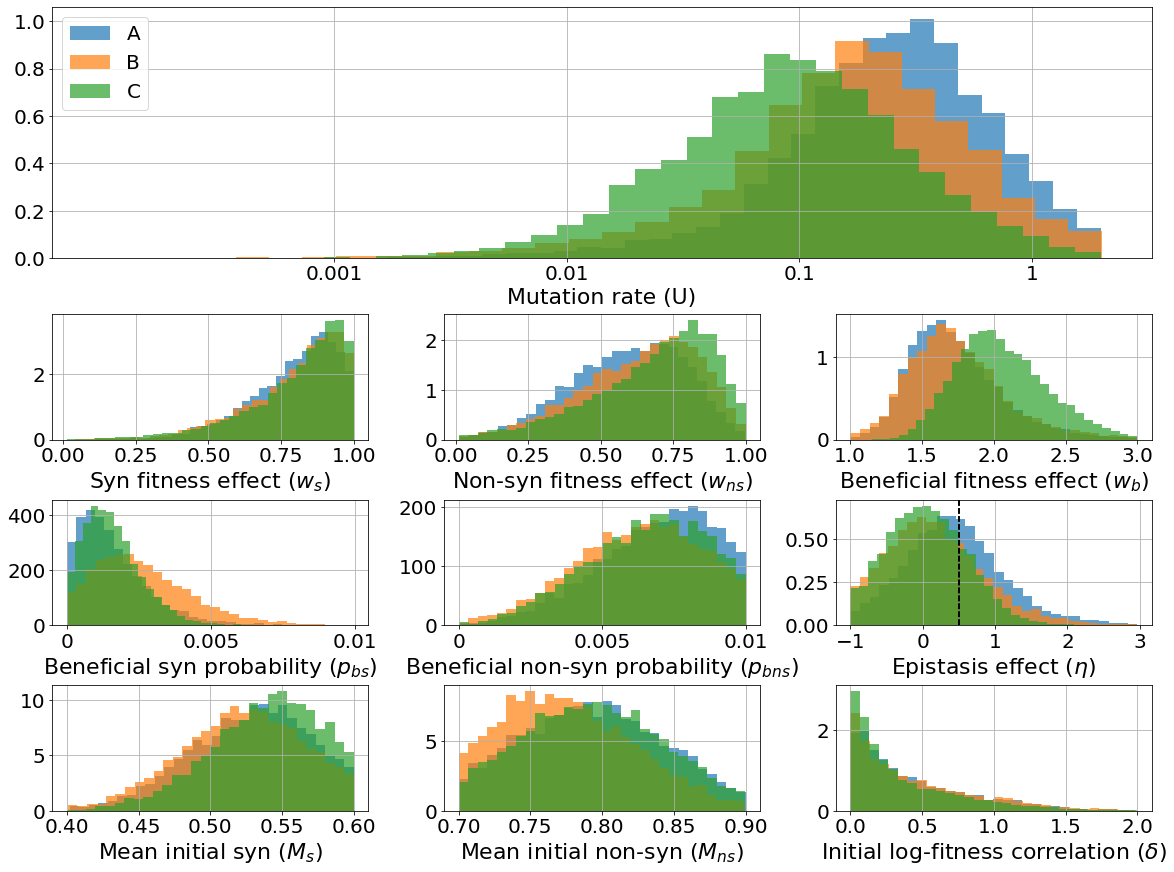

In [14]:
compare_posts_across_lines(inf_LR)

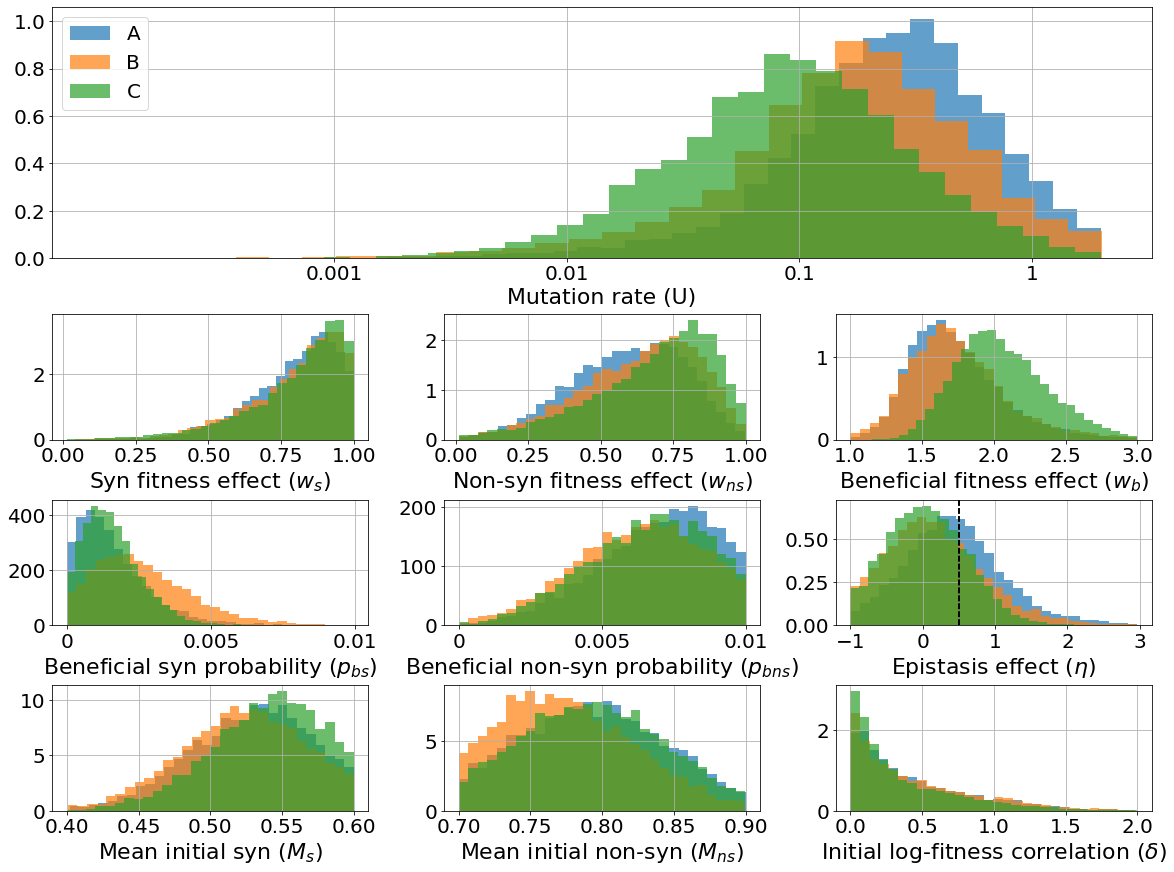

In [15]:
compare_posts_across_lines(inf_LR)

# L-LR Inference

In [16]:
inf_LLR = {}

## Figure 6

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.495500 -9.870305e-01  1.332297   -0.066607  -0.658165   
1            w_syn  0.890000  6.591816e-01  1.285225    0.999935   0.832119   
2        w_non_syn  0.748000  4.074604e-01  0.958477    0.937570   0.641390   
3            w_ada  1.728500  1.457976e+00  1.328959    2.128129   1.642928   
4        p_ada_syn  0.000794  1.168667e-08  1.627316    0.002134   0.000283   
5    p_ada_non_syn  0.005860  3.018539e-03  0.741754    0.009963   0.005214   
6           p0_syn  0.517000  4.179854e-01  0.646295    0.590701   0.472420   
7       p0_non_syn  0.821000  7.053884e-01  0.629726    0.880476   0.754085   
8        w_penalty  0.109850  1.625906e-05  0.809802    1.436061   0.000016   
9  epistasis_boost -0.057200 -9.999649e-01  1.142241    0.514385  -0.543067   

   hdi50_high     model  
0   -0.346612  ensemble  
1    0.946104  ensemble  
2    0.826460  ensemble  
3    1.856583  ensemble  


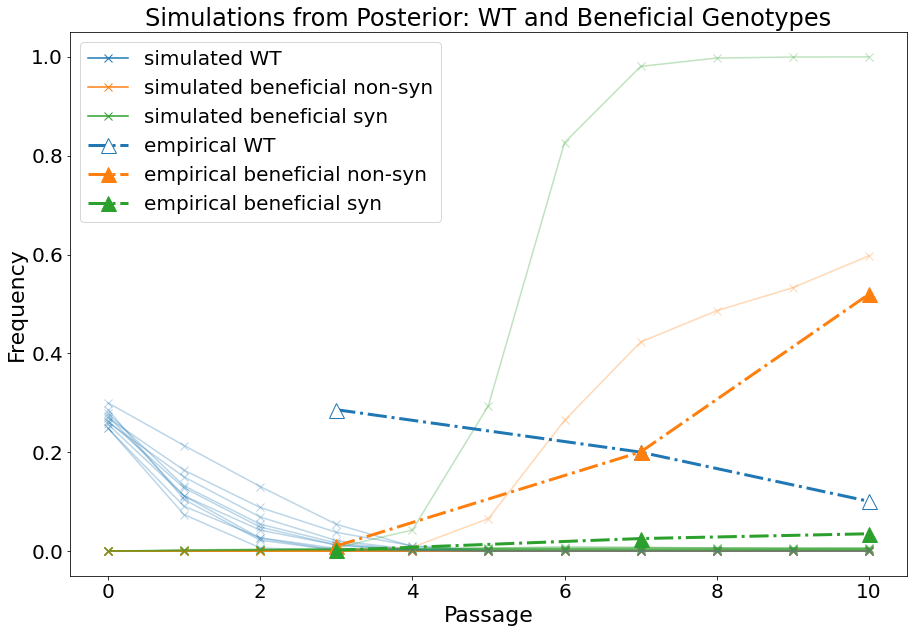

In [17]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=True, samples_per_model=1000, syn_prob=syn_prob)


In [18]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.673500  -1.163464  1.737758   -0.255844  -0.901759   
1            w_syn  0.877500   0.613260  1.184293    0.999950   0.805096   
2        w_non_syn  0.706500   0.246112  0.830969    0.886604   0.540810   
3            w_ada  1.758500   1.513874  1.505445    2.023041   1.701216   
4        p_ada_syn  0.001560   0.000013  1.481171    0.002565   0.000723   
5    p_ada_non_syn  0.007805   0.003399  0.772459    0.009989   0.005831   
6           p0_syn  0.499000   0.429756  0.642685    0.599889   0.479158   
7       p0_non_syn  0.799000   0.705213  0.619028    0.880173   0.768507   
8        w_penalty  0.050000   0.000073  1.238786    0.853652   0.004614   
9  epistasis_boost -0.386000  -0.993741  1.185487    0.437288  -0.604432   

   hdi50_high     model  
0   -0.593455  ensemble  
1    0.936392  ensemble  
2    0.769324  ensemble  
3    1.877310  ensemble  
4    0.001675  ensemble  
5    0.

In [19]:
errs = '5e-05'
sumstat_type = 'L-LR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.898000 -1.357440e+00  2.076483   -0.407615  -1.073968   
1            w_syn  0.925500  6.901518e-01  1.342901    0.999912   0.875911   
2        w_non_syn  0.672500  3.005402e-01  0.861957    0.915702   0.567189   
3            w_ada  1.992500  1.741638e+00  1.381108    2.350858   1.910612   
4        p_ada_syn  0.000414  2.052038e-06  1.780129    0.001766   0.000343   
5    p_ada_non_syn  0.006650  3.068063e-03  0.753823    0.009987   0.004786   
6           p0_syn  0.517000  4.289307e-01  0.657917    0.595748   0.483269   
7       p0_non_syn  0.813000  7.178432e-01  0.634281    0.891207   0.760269   
8        w_penalty  0.025000  5.474852e-07  1.443183    0.680246   0.000655   
9  epistasis_boost -0.342000 -9.994140e-01  1.217404    0.368125  -0.651434   

   hdi50_high     model  
0   -0.758711  ensemble  
1    0.986486  ensemble  
2    0.784404  ensemble  
3    2.116276  ensemble  


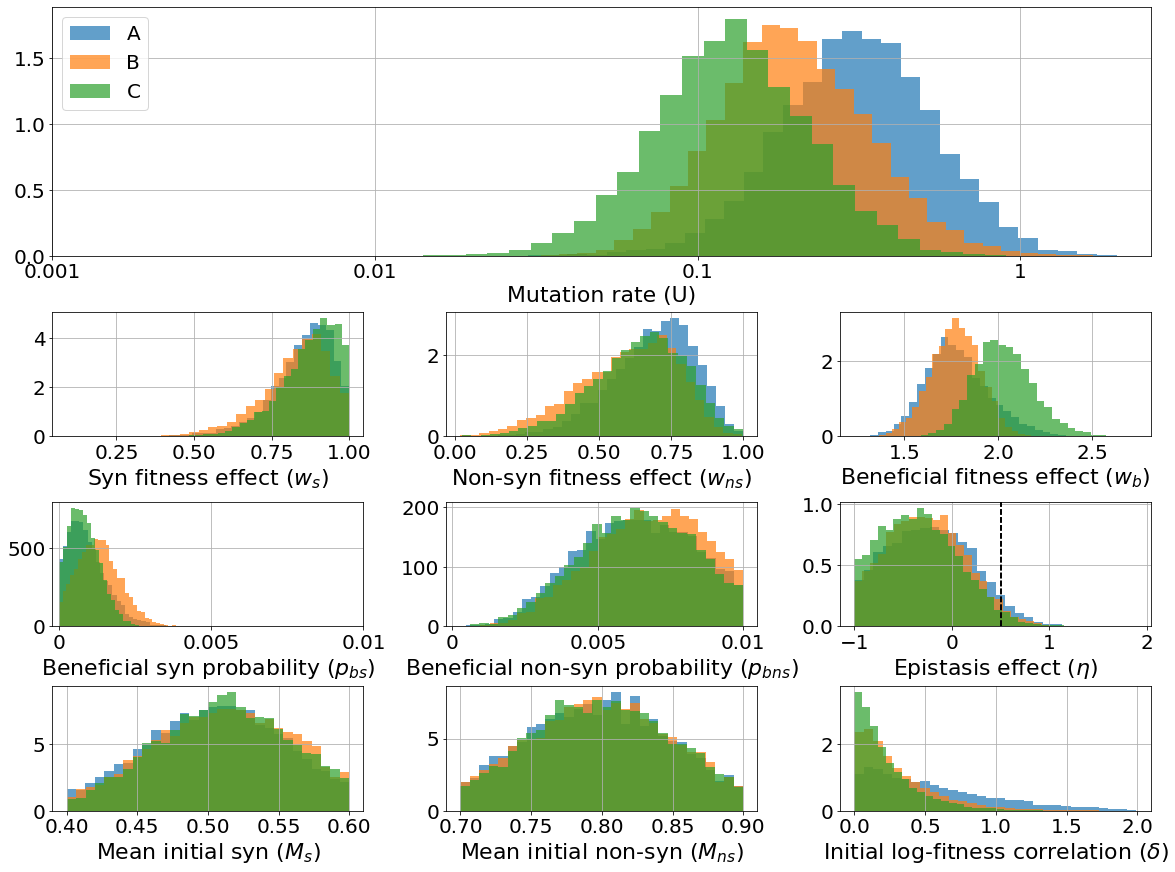

In [20]:
compare_posts_across_lines(inf_LLR)

# SR Inference

In [21]:
inf_SR = {}

In [22]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'A'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.65400  -1.748501  1.377524    0.180747  -1.053921   
1            w_syn  0.90700   0.459289  0.979221    0.999552   0.811064   
2        w_non_syn  0.75800   0.268170  0.728549    0.991557   0.616101   
3            w_ada  2.19100   1.349320  0.712404    2.914189   1.830390   
4        p_ada_syn  0.00205   0.000002  0.868284    0.006230   0.000901   
5    p_ada_non_syn  0.00715   0.002691  0.713163    0.009999   0.005243   
6           p0_syn  0.54300   0.462289  0.783920    0.599981   0.523425   
7       p0_non_syn  0.79700   0.700416  0.645739    0.872074   0.751585   
8        w_penalty  0.02995   0.000056  1.086442    1.264569   0.000056   
9  epistasis_boost  0.12300  -0.999061  0.915688    1.297413  -0.343360   

   hdi50_high     model  
0   -0.364179  ensemble  
1    0.984854  ensemble  
2    0.897962  ensemble  
3    2.413874  ensemble  
4    0.003043  ensemble  
5    0.008283  ens

In [23]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'B'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.916000  -1.919415  1.427564    0.167669  -1.200848   
1            w_syn  0.917000   0.471069  0.965749    0.999904   0.814775   
2        w_non_syn  0.718000   0.242022  0.706816    0.974176   0.607604   
3            w_ada  2.235500   1.322128  0.684826    2.929512   1.833330   
4        p_ada_syn  0.002825   0.000008  0.778527    0.006886   0.001429   
5    p_ada_non_syn  0.007850   0.002463  0.710422    0.009990   0.005769   
6           p0_syn  0.567000   0.455128  0.741974    0.599981   0.515068   
7       p0_non_syn  0.753000   0.700285  0.642765    0.865377   0.734187   
8        w_penalty  0.029850   0.000047  1.000622    1.418896   0.000047   
9  epistasis_boost -0.021540  -0.999480  0.896677    1.388532  -0.399215   

   hdi50_high     model  
0   -0.423065  ensemble  
1    0.990662  ensemble  
2    0.900458  ensemble  
3    2.457664  ensemble  
4    0.003964  ensemble  
5    0.

In [24]:
errs = '5e-05'
sumstat_type = 'SR'
replica = 'C'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
inf_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.850500  -1.793212  1.353022    0.201403  -1.092395   
1            w_syn  0.887000   0.435145  0.938356    0.999476   0.783399   
2        w_non_syn  0.856000   0.294597  0.738002    0.994222   0.601596   
3            w_ada  2.090000   1.398692  0.711767    2.943213   1.861151   
4        p_ada_syn  0.001825   0.000015  0.887197    0.005758   0.001016   
5    p_ada_non_syn  0.008050   0.002670  0.713514    0.009990   0.006038   
6           p0_syn  0.521000   0.447403  0.708891    0.599789   0.511467   
7       p0_non_syn  0.789000   0.702748  0.666334    0.867757   0.755170   
8        w_penalty  0.030000   0.000012  0.998096    1.419309   0.000012   
9  epistasis_boost -0.026030  -0.997227  0.940495    1.137990  -0.342157   

   hdi50_high     model  
0   -0.371416  ensemble  
1    0.973691  ensemble  
2    0.885720  ensemble  
3    2.441713  ensemble  
4    0.003090  ensemble  
5    0.

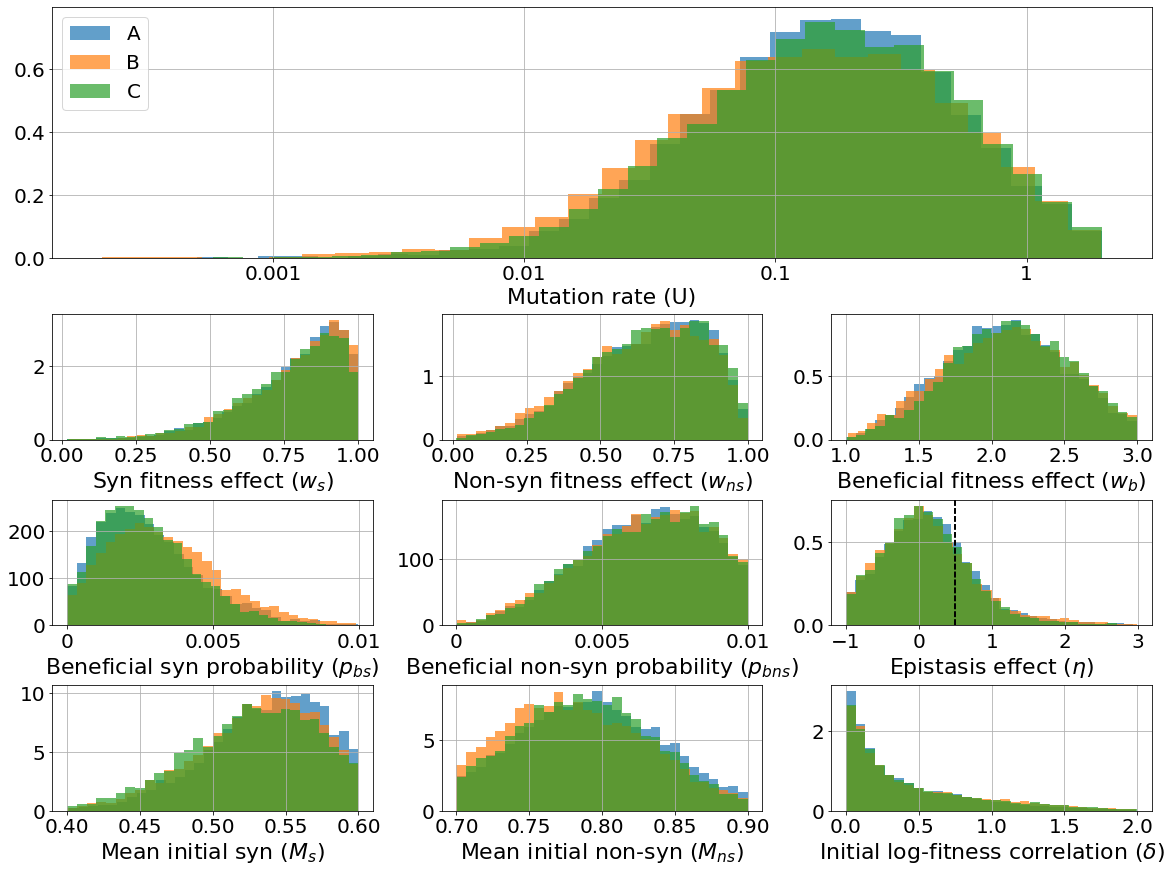

In [25]:
compare_posts_across_lines(inf_SR)

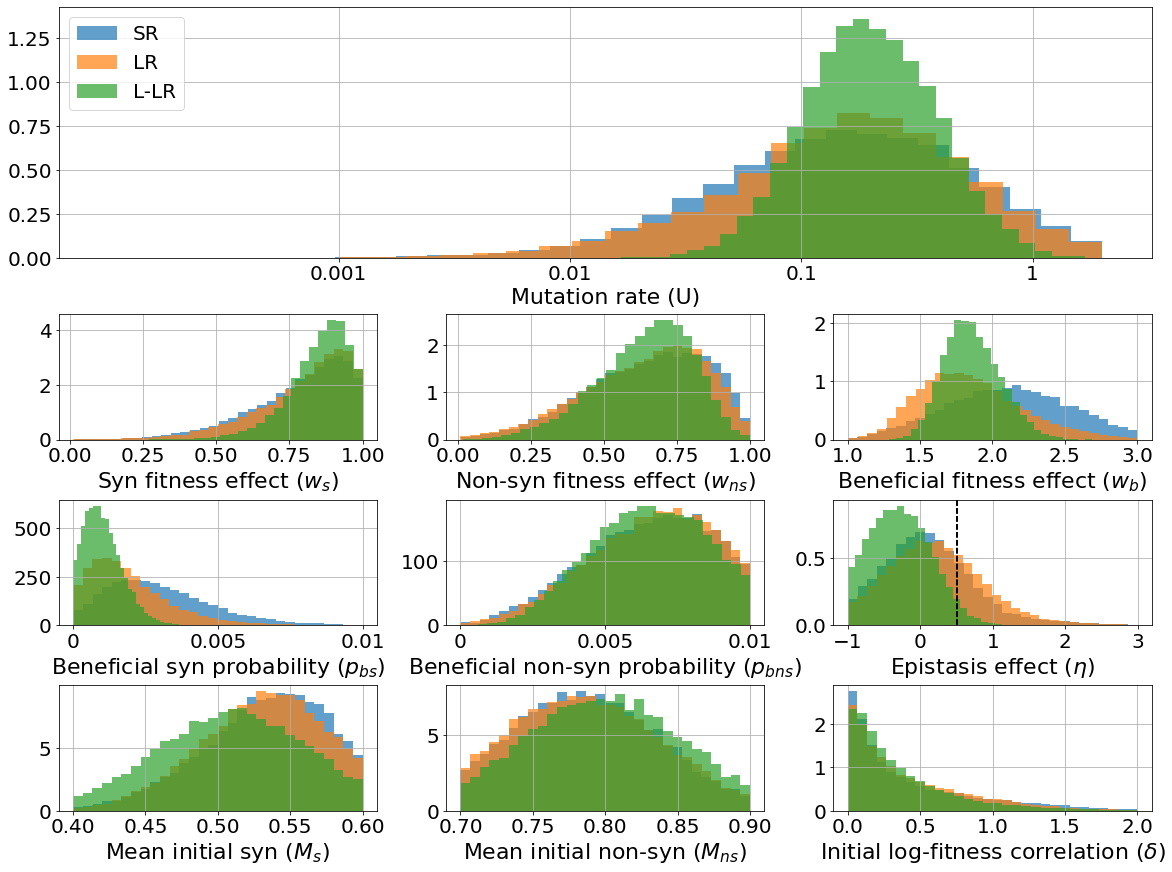

In [26]:
all_posts = {'SR': pd.concat([x[0] for x in inf_SR.values()]),
             'LR': pd.concat([x[0] for x in inf_LR.values()]),
             'L-LR': pd.concat([x[0] for x in inf_LLR.values()])}
compare_posts(all_posts)

## Fig 4A

This code block requires FITS posterior file (FITS_post.tsv) which can be download from [Zenodo](https://zenodo.org/record/7486851/files/FITS_post.tar.gz?download=1)


In [27]:
def plot_post_estimates(ax):
    fits_post = pd.read_table('FITS/FITS_post.tsv')
    sample_size = 10000
    bin_num = 30
    alpha = 0.6
    fits_post.log_U.sample(sample_size).hist(bins=bin_num, ax=ax, label='FITS', density=True, color=sns.color_palette()[7])
    all_posts['SR']['Mutation rate (U)'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='SR', 
                                                               density=True,ax=ax)
    all_posts['LR']['Mutation rate (U)'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='LR', 
                                                               density=True, ax=ax)
    all_posts['L-LR']['Mutation rate (U)'].sample(sample_size).hist(bins=bin_num, alpha=alpha, label='L-LR', 
                                                                 density=True, ax=ax)
    xticks = [-3,-2,-1, 0, 1]
    ax.set_xticks(xticks)
    ax.set_xticklabels([10**x for x in xticks])
    ax.set_yticks([0,0.5,1,1.5])
    stop_codon_estimate = np.log10(0.187)
    ax.axvline(stop_codon_estimate, ls='--', color='k', ymax=1.5)
    handles, labels = ax.get_legend_handles_labels()
    #line = plt.Line2D([0], [0], label='Premature\nstop codons\nestimate', color='k', ls='--')
    #handles.extend([line])
    ax.legend(handles=handles)
    ax.set_xlabel('Mutation rate (U)')

def compare_posts_for_paper(posts, title_suffix='', colors=None, alpha=0.7, mu_xticks=(-3,1), legend_loc=(0.42,0.46)):
    mosaic = """
        AAA
        AAA
        BCD
        EFG
        """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'E', 
                          r'Beneficial fitness effect ($w_{b}$)': 'D', 
                          r'Epistasis effect ($\eta$)': 'G', 
                          r'Beneficial non-syn probability ($p_{bns}$)': 'F'}
    if not colors:
        colors = sns.color_palette(None)
    legend = True
    for col_name, ax_index in param_to_plot_dict.items():
        ax = ax_dict[ax_index]
        if 'Mutation' in col_name:
            col = 'err'
            plot_post_estimates(ax)
        else:
            col = 'rel_err'
            for i, (name, df) in enumerate(posts.items()):
                df[col_name].hist(bins=20, label=name if legend else '_nolegend', ax=ax, alpha=alpha, color=colors[i], density=True)
                if 'probability' in col_name:
                    xticks = [0, 0.005, 0.01]
                    ax.set_xticks(xticks)
                    ax.set_xticklabels(xticks)
                if 'stasis' in col_name:
                    ax.axvline(0.5, ls='--', color='k')    
            ax.set_xlabel(col_name)
            if ax_index in ['A', 'B', 'E']:
                ax.set_ylabel('Density', size=25)
            legend = False
    


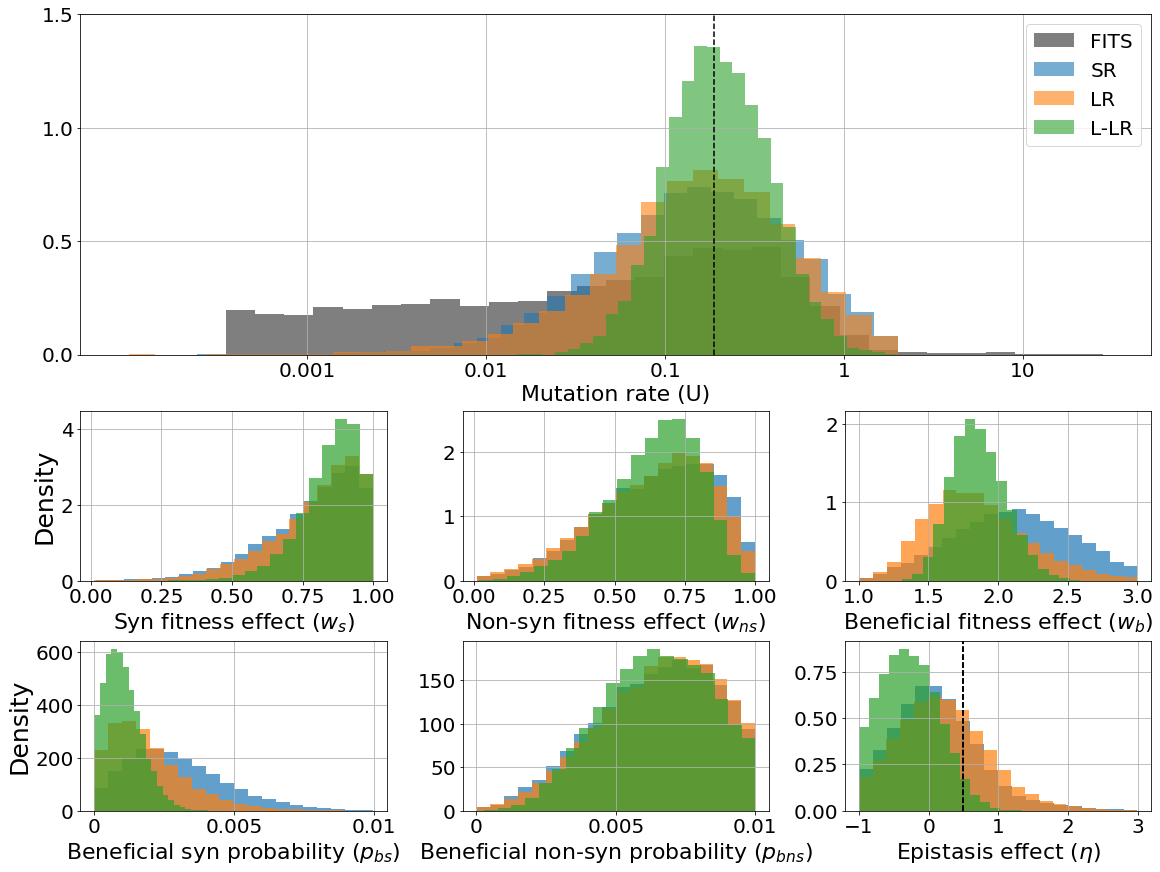

In [28]:
compare_posts_for_paper({'SR': all_posts['SR'], 'LR': all_posts['LR'], 'L-LR': all_posts['L-LR']})

## Table 1 + Table S2 data

In [29]:
all_posts_tmp = {k :v.rename(columns={v:k for k,v in rename_dict.items()}) for k,v in all_posts.items()}
stats = {k : calc_stats(v, None, prior) for k,v in all_posts_tmp.items()}
for k, v in stats.items():
    for param in v.param.unique():
        print(k)
        print(param)
        print(v[v.param==param][['hdi95_low', 'mode', 'hdi95_high']])

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


SR
mu
   hdi95_low    mode  hdi95_high
0  -1.837482 -0.9935    0.172968
SR
w_ada
   hdi95_low  mode  hdi95_high
1   1.343082  2.19     2.92183
SR
w_syn
   hdi95_low   mode  hdi95_high
2   0.453806  0.926    0.999974
SR
w_non_syn
   hdi95_low   mode  hdi95_high
3   0.265091  0.718    0.989341
SR
p_ada_non_syn
   hdi95_low     mode  hdi95_high
4   0.002589  0.00745    0.009987
SR
p_ada_syn
   hdi95_low     mode  hdi95_high
5   0.000001  0.00205    0.006326
SR
p0_non_syn
   hdi95_low   mode  hdi95_high
6   0.700581  0.785    0.868258
SR
p0_syn
   hdi95_low   mode  hdi95_high
7   0.454778  0.545    0.599947
SR
w_penalty
   hdi95_low  mode  hdi95_high
8   0.000003  0.03    1.371871
SR
epistasis_boost
   hdi95_low     mode  hdi95_high
9  -0.994319 -0.02154    1.270393
LR
mu
   hdi95_low    mode  hdi95_high
0  -1.841621 -0.7105    0.173644
LR
w_ada
   hdi95_low   mode  hdi95_high
1   1.228285  1.612     2.60357
LR
w_syn
   hdi95_low    mode  hdi95_high
2   0.479019  0.9555    0.999964
LR
w_no

# Large Errors (10x loop errs)

In [30]:
large_errs_LLR = {}

In [31]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.900500  -1.463529  1.881578   -0.294348  -1.101857   
1            w_syn  0.849500   0.659876  1.285262    0.998994   0.797095   
2        w_non_syn  0.477000   0.120750  0.873778    0.715958   0.356840   
3            w_ada  1.863500   1.563484  1.346147    2.215765   1.738316   
4        p_ada_syn  0.000615   0.000007  1.831570    0.001697   0.000429   
5    p_ada_non_syn  0.008205   0.004084  0.834001    0.010000   0.007098   
6           p0_syn  0.509000   0.418197  0.628840    0.590631   0.467844   
7       p0_non_syn  0.779000   0.716207  0.651171    0.888316   0.767269   
8        w_penalty  0.347000   0.022541  0.833403    1.343135   0.200655   
9  epistasis_boost -0.569000  -0.999972  1.190941    0.430292  -0.796041   

   hdi50_high     model  
0   -0.698471  ensemble  
1    0.911380  ensemble  
2    0.567688  ensemble  
3    1.948245  ensemble  
4    0.001054  ensemble  
5    0.

In [32]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.335000 -8.032543e-01  1.158147    0.074363  -0.506529   
1            w_syn  0.673500  4.930772e-01  1.189043    0.876553   0.628922   
2        w_non_syn  0.284500  5.340446e-02  1.081865    0.495908   0.199767   
3            w_ada  1.769500  1.549326e+00  1.408859    2.125027   1.689179   
4        p_ada_syn  0.000726  6.960585e-08  1.814012    0.001687   0.000266   
5    p_ada_non_syn  0.001990  5.233351e-04  1.155894    0.004728   0.001653   
6           p0_syn  0.515000  4.042364e-01  0.638313    0.576566   0.457506   
7       p0_non_syn  0.787000  7.079690e-01  0.625875    0.883012   0.750751   
8        w_penalty  1.934500  8.753459e-01  0.949260    1.999984   1.631949   
9  epistasis_boost -0.230500 -9.960169e-01  1.156711    0.557039  -0.454051   

   hdi50_high     model  
0   -0.215467  ensemble  
1    0.756920  ensemble  
2    0.355514  ensemble  
3    1.889761  ensemble  


In [33]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'L-LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LLR[replica] = infer_and_plot(ensemble_path, loop_coding_man[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode     hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.819000 -1.240169e+00  1.491118   -0.019050  -0.924586   
1            w_syn  0.870500  7.028753e-01  1.388312    0.994733   0.818770   
2        w_non_syn  0.426000  1.419049e-01  0.985932    0.652972   0.347258   
3            w_ada  1.938500  1.592981e+00  1.322096    2.247820   1.837841   
4        p_ada_syn  0.000807  6.345438e-07  1.816591    0.001673   0.000340   
5    p_ada_non_syn  0.004900  1.970986e-03  0.850086    0.008397   0.003457   
6           p0_syn  0.483000  4.008158e-01  0.633941    0.573237   0.452751   
7       p0_non_syn  0.795000  7.055710e-01  0.621070    0.880375   0.761947   
8        w_penalty  1.511000  6.393640e-01  0.789560    1.999901   1.423343   
9  epistasis_boost -0.418500 -9.998682e-01  1.200970    0.411535  -0.718757   

   hdi50_high     model  
0   -0.519522  ensemble  
1    0.919255  ensemble  
2    0.526046  ensemble  
3    2.058375  ensemble  


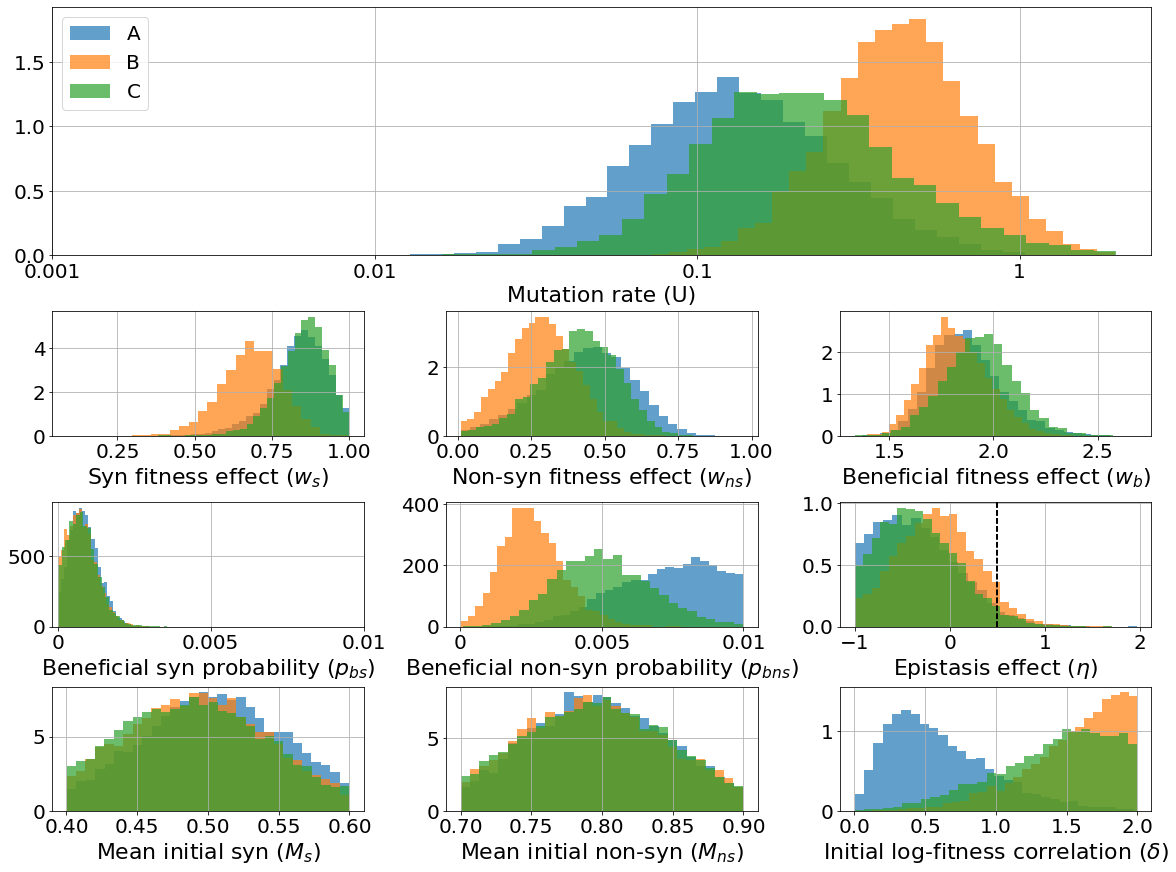

In [34]:
compare_posts_across_lines(large_errs_LLR)

## Fig 4B + S?

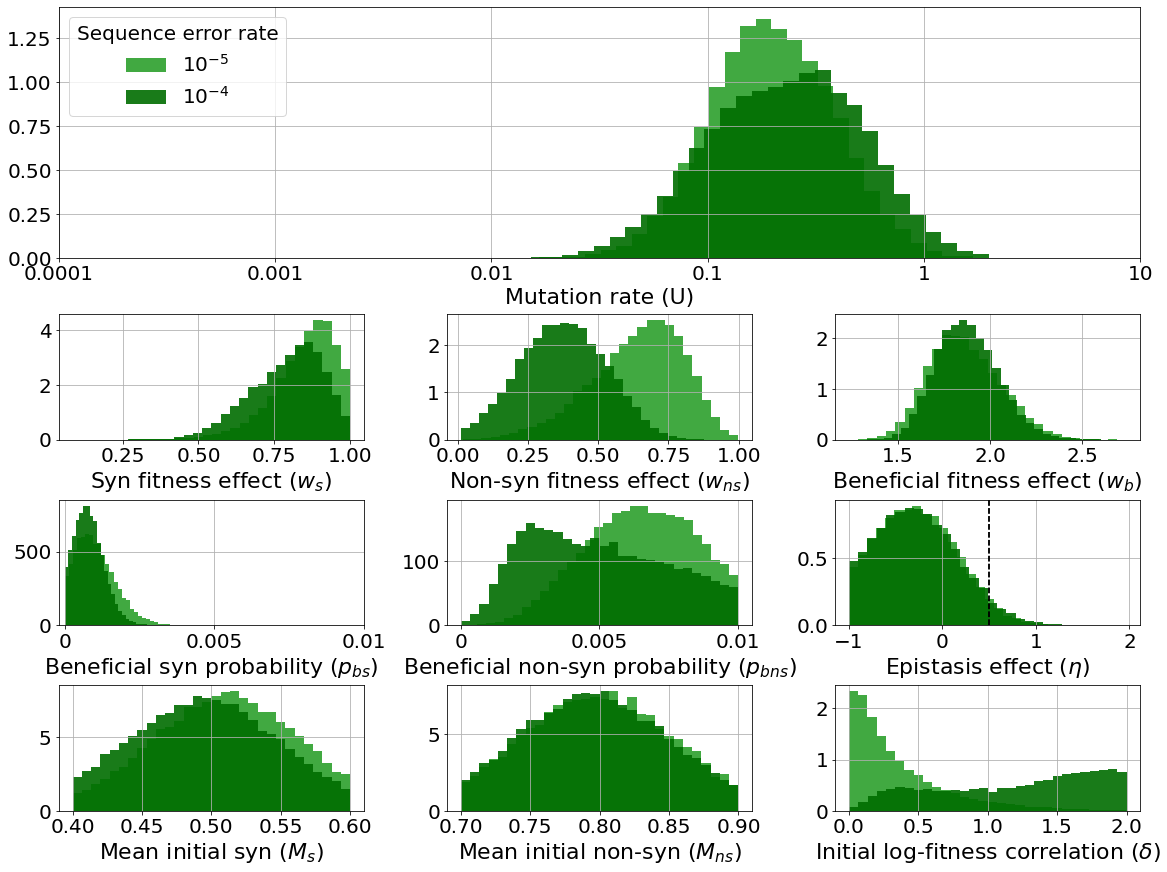

In [35]:
man_errs = {r'$10^{-5}$': pd.concat([x[0] for x in inf_LLR.values()]),
            r'$10^{-4}$': pd.concat([x[0] for x in large_errs_LLR.values()])}
not_C2 = [max(x-0.2,0) for x in sns.color_palette()[2]]
compare_posts(man_errs, mu_xticks=(-4,2), legend_title='Sequence error rate',
                             colors=['C2', not_C2], alpha=0.9)

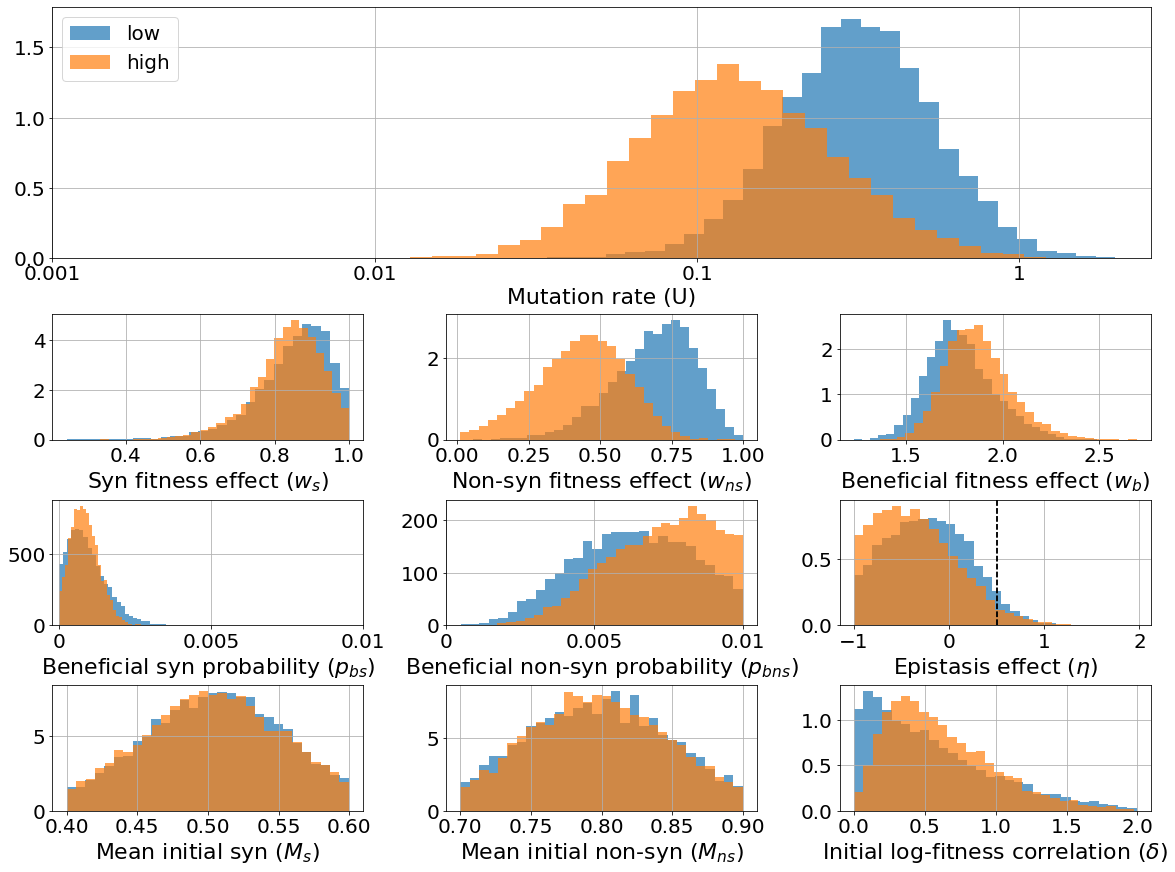

In [36]:
replica = 'A'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

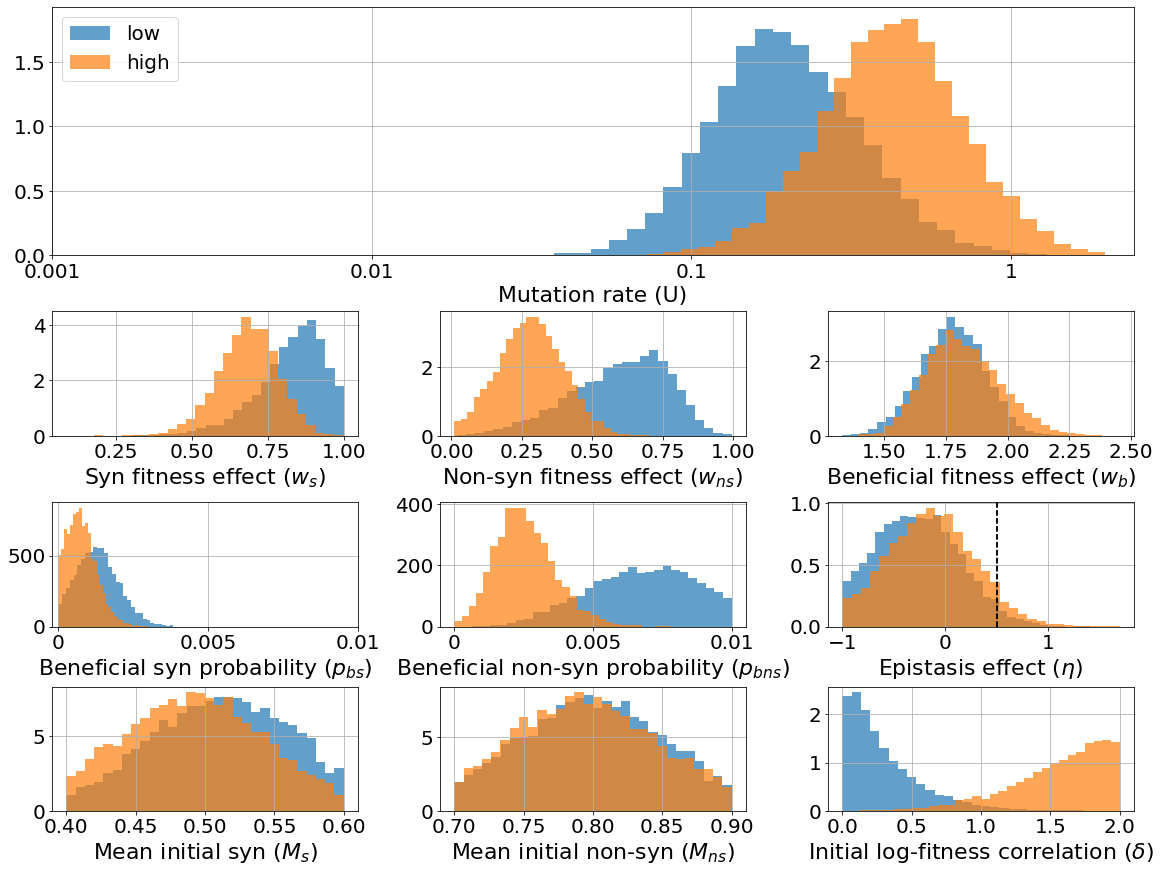

In [37]:
replica = 'B'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

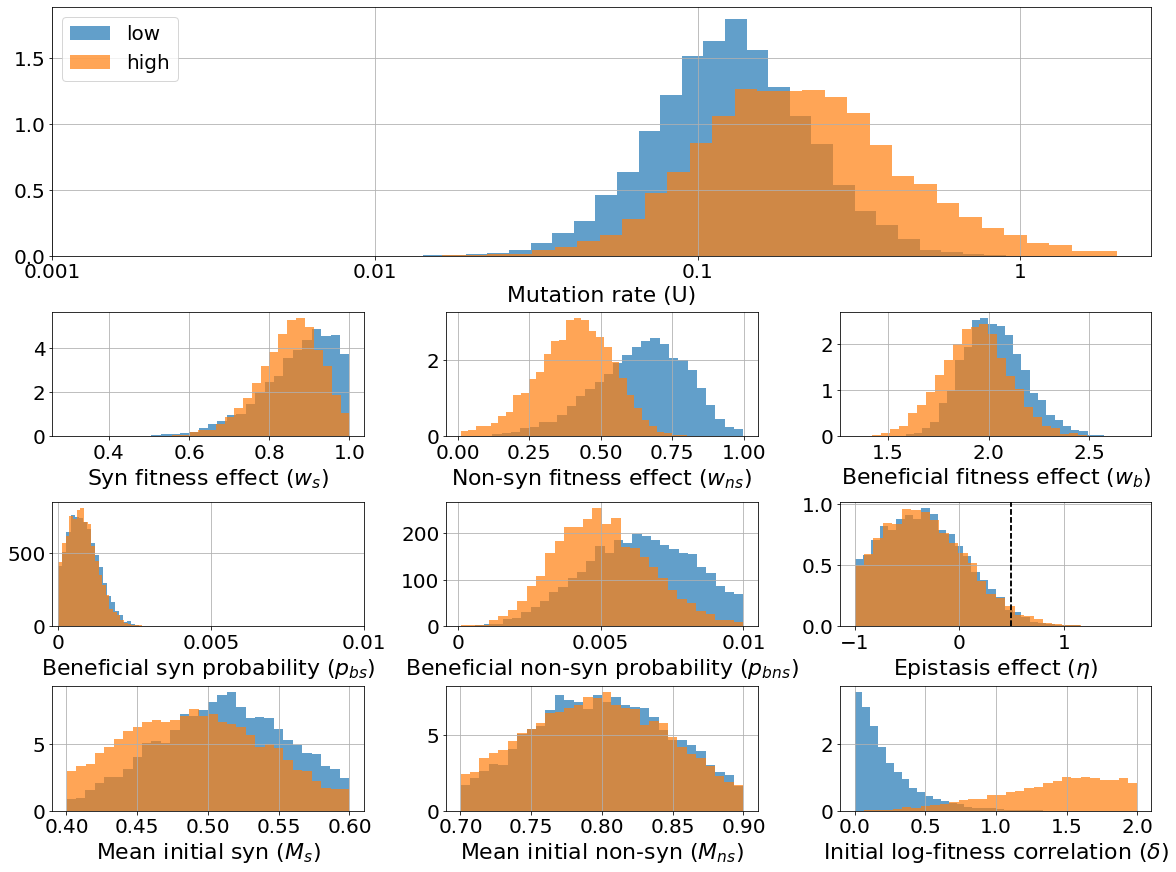

In [38]:
replica = 'C'
compare_posts({'low': inf_LLR[replica][0], 'high': large_errs_LLR[replica][0]})

In [39]:
large_errs_LR = {}

In [40]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -3.09050  -3.962003  6.401565   -2.321752  -3.383752   
1            w_syn  0.79550   0.464362  1.016090    0.966661   0.710734   
2        w_non_syn  0.35050   0.012117  0.727365    0.710712   0.173643   
3            w_ada  2.75600   2.337992  1.256181    2.999885   2.610801   
4        p_ada_syn  0.00225   0.000210  0.943103    0.005829   0.001664   
5    p_ada_non_syn  0.00737   0.002980  0.775807    0.009999   0.005620   
6           p0_syn  0.53100   0.455562  0.722619    0.599907   0.506567   
7       p0_non_syn  0.82900   0.732092  0.658191    0.898818   0.787771   
8        w_penalty  0.20950   0.046055  1.153337    1.006751   0.149101   
9  epistasis_boost  1.63350   0.773166  0.994321    2.787016   1.340709   

   hdi50_high     model  
0   -2.825526  ensemble  
1    0.875493  ensemble  
2    0.473153  ensemble  
3    2.882075  ensemble  
4    0.003604  ensemble  
5    0.008244  ens

In [41]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.963000  -1.663316  1.857591   -0.230806  -1.203586   
1            w_syn  0.831000   0.540764  1.153800    0.957294   0.770089   
2        w_non_syn  0.353000   0.034107  0.897282    0.594711   0.187736   
3            w_ada  1.817000   1.357693  0.947661    2.472264   1.725994   
4        p_ada_syn  0.003145   0.000699  0.894687    0.006560   0.002263   
5    p_ada_non_syn  0.007355   0.002657  0.713506    0.009996   0.005571   
6           p0_syn  0.463000   0.402543  0.633230    0.572437   0.448443   
7       p0_non_syn  0.817000   0.710401  0.628188    0.884732   0.756722   
8        w_penalty  1.163500   0.248890  0.660548    1.853732   0.569055   
9  epistasis_boost  1.070000   0.549188  1.537232    1.737845   0.866010   

   hdi50_high     model  
0   -0.715304  ensemble  
1    0.901424  ensemble  
2    0.406929  ensemble  
3    2.099530  ensemble  
4    0.004311  ensemble  
5    0.

In [42]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'LR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_LR[replica] = infer_and_plot(ensemble_path, loop_coding[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.013805  -0.509837  0.738871    0.296467  -0.177503   
1            w_syn  0.588500   0.347590  0.989781    0.826878   0.518522   
2        w_non_syn  0.136500   0.010185  1.173268    0.391005   0.074988   
3            w_ada  1.287000   1.051147  1.287968    1.736249   1.251940   
4        p_ada_syn  0.003210   0.000087  0.842163    0.006604   0.001948   
5    p_ada_non_syn  0.008160   0.003539  0.797748    0.009999   0.006537   
6           p0_syn  0.493000   0.400915  0.646918    0.567461   0.443330   
7       p0_non_syn  0.817000   0.711512  0.627396    0.886122   0.758240   
8        w_penalty  1.631500   0.654166  0.799525    1.999980   1.449062   
9  epistasis_boost -0.347000  -0.998596  0.889273    1.352530  -0.629721   

   hdi50_high     model  
0    0.127170  ensemble  
1    0.699918  ensemble  
2    0.213842  ensemble  
3    1.477861  ensemble  
4    0.004212  ensemble  
5    0.

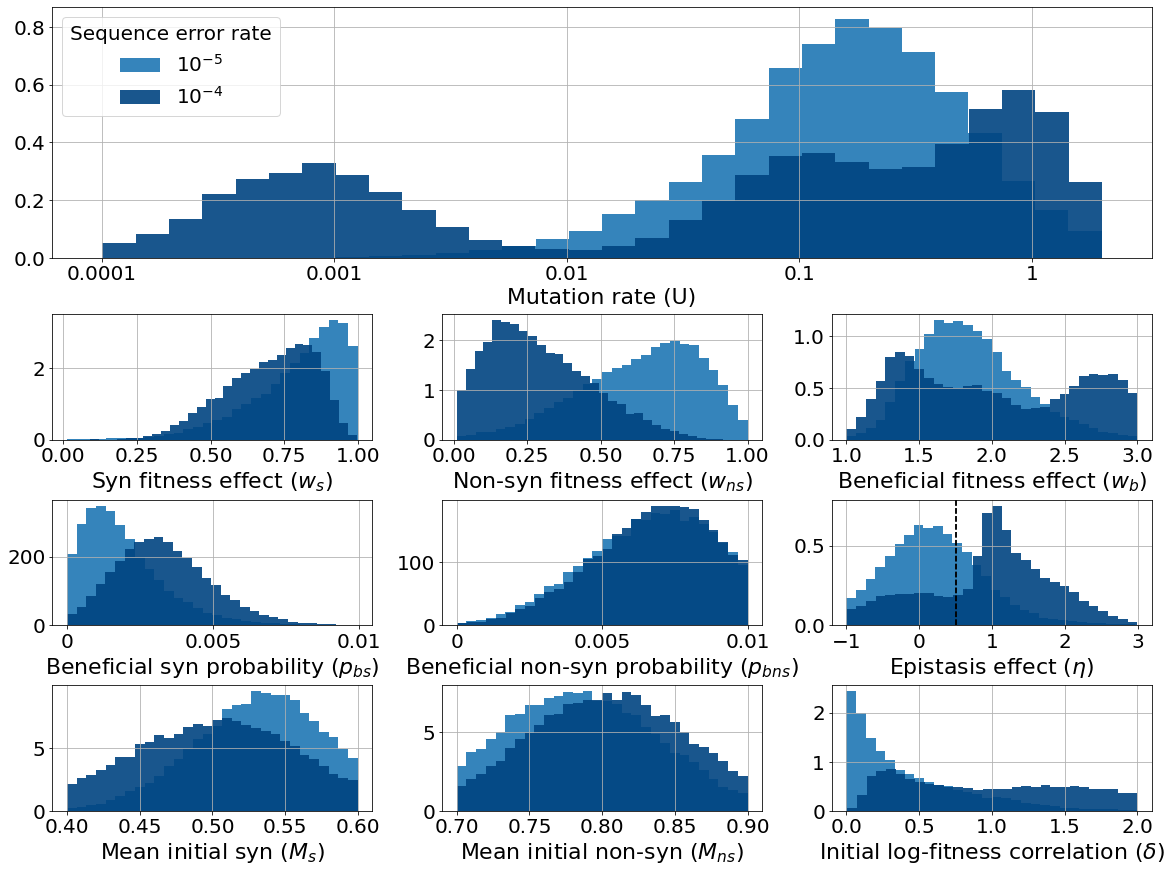

In [43]:
LR_errs = {r'$10^{-5}$': pd.concat([x[0] for x in inf_LR.values()]),
            r'$10^{-4}$': pd.concat([x[0] for x in large_errs_LR.values()])}
not_C0 = [max(x-0.2,0) for x in sns.color_palette()[0]]
compare_posts(LR_errs, mu_xticks=(-4,1), legend_title='Sequence error rate',
                             colors=['C0', not_C0], alpha=0.9)

In [44]:
large_errs_SR = {}

In [45]:
errs = '5e-04'
replica = 'A'
sumstat_type = 'SR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -3.55450  -3.999362  5.913417   -1.805527  -3.704140   
1            w_syn  0.86200   0.493412  1.006926    0.999697   0.769783   
2        w_non_syn  0.30200   0.016955  0.696013    0.750758   0.230126   
3            w_ada  2.25350   1.466996  0.675402    2.998538   1.920110   
4        p_ada_syn  0.00305   0.000002  0.687836    0.008008   0.001299   
5    p_ada_non_syn  0.00636   0.001874  0.651508    0.009995   0.004215   
6           p0_syn  0.53900   0.462286  0.762162    0.599999   0.520588   
7       p0_non_syn  0.84500   0.736416  0.650154    0.899390   0.805780   
8        w_penalty  0.24900   0.063253  1.125027    1.107112   0.140767   
9  epistasis_boost  2.24200   1.175998  1.000552    2.999085   1.763113   

   hdi50_high     model  
0   -2.834166  ensemble  
1    0.935220  ensemble  
2    0.555220  ensemble  
3    2.611309  ensemble  
4    0.004403  ensemble  
5    0.007593  ens

In [46]:
errs = '5e-04'
replica = 'B'
sumstat_type = 'SR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param      mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -1.070500  -2.251853  1.980595   -0.061299  -1.522302   
1            w_syn  0.884000   0.497990  1.128016    0.955831   0.785406   
2        w_non_syn  0.334000   0.046139  0.834138    0.642244   0.193085   
3            w_ada  2.391000   1.449472  0.680521    2.998063   2.139828   
4        p_ada_syn  0.003145   0.000932  0.775912    0.007939   0.002901   
5    p_ada_non_syn  0.006860   0.002774  0.744899    0.009943   0.005435   
6           p0_syn  0.455000   0.400035  0.616099    0.572737   0.446815   
7       p0_non_syn  0.799000   0.710450  0.639213    0.884635   0.765894   
8        w_penalty  0.733500   0.233403  0.668343    1.843607   0.428558   
9  epistasis_boost  0.804000  -0.184618  1.004641    2.048532   0.459849   

   hdi50_high     model  
0   -0.762536  ensemble  
1    0.916729  ensemble  
2    0.440321  ensemble  
3    2.786663  ensemble  
4    0.005430  ensemble  
5    0.

In [47]:
errs = '5e-04'
replica = 'C'
sumstat_type = 'SR'
ensemble_path = get_ensemble_path(errs, replica, sumstat_type)
large_errs_SR[replica] = infer_and_plot(ensemble_path, loop_coding_short[replica], man_sumstat=loop_coding_man[replica],
                                   sumstats_to_simulate=10, plot_hdi=False, plot_freqs=False, plot_short_PPC=False,
                                   plot_long_PPC=False, samples_per_model=1000, syn_prob=syn_prob)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: divide by zero encountered in log
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))
/sternadi/home/volume2/ita/ms2-mutation-rate/utils.py:60: RuntimeWarning: invalid value encountered in multiply
  divergence = np.sum(np.where(P!=0, P*np.log(P/Q), 0))


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

             param     mode  hdi95_low       DKL  hdi95_high  hdi50_low  \
0               mu -0.24450  -0.751603  0.786870    0.294367  -0.350051   
1            w_syn  0.58950   0.300092  0.911844    0.846569   0.420924   
2        w_non_syn  0.07965   0.010344  1.180716    0.407264   0.026687   
3            w_ada  2.35100   1.774599  0.823386    2.999406   2.226967   
4        p_ada_syn  0.00415   0.000815  0.848809    0.007112   0.002695   
5    p_ada_non_syn  0.00766   0.003355  0.782864    0.009993   0.006703   
6           p0_syn  0.49700   0.410757  0.623868    0.589375   0.466671   
7       p0_non_syn  0.80300   0.704782  0.607203    0.883525   0.748017   
8        w_penalty  1.18650   0.442306  0.684691    1.960202   0.905887   
9  epistasis_boost -0.50400  -0.999648  1.169779    0.473619  -0.658396   

   hdi50_high     model  
0    0.034635  ensemble  
1    0.637866  ensemble  
2    0.162104  ensemble  
3    2.720855  ensemble  
4    0.004895  ensemble  
5    0.009392  ens

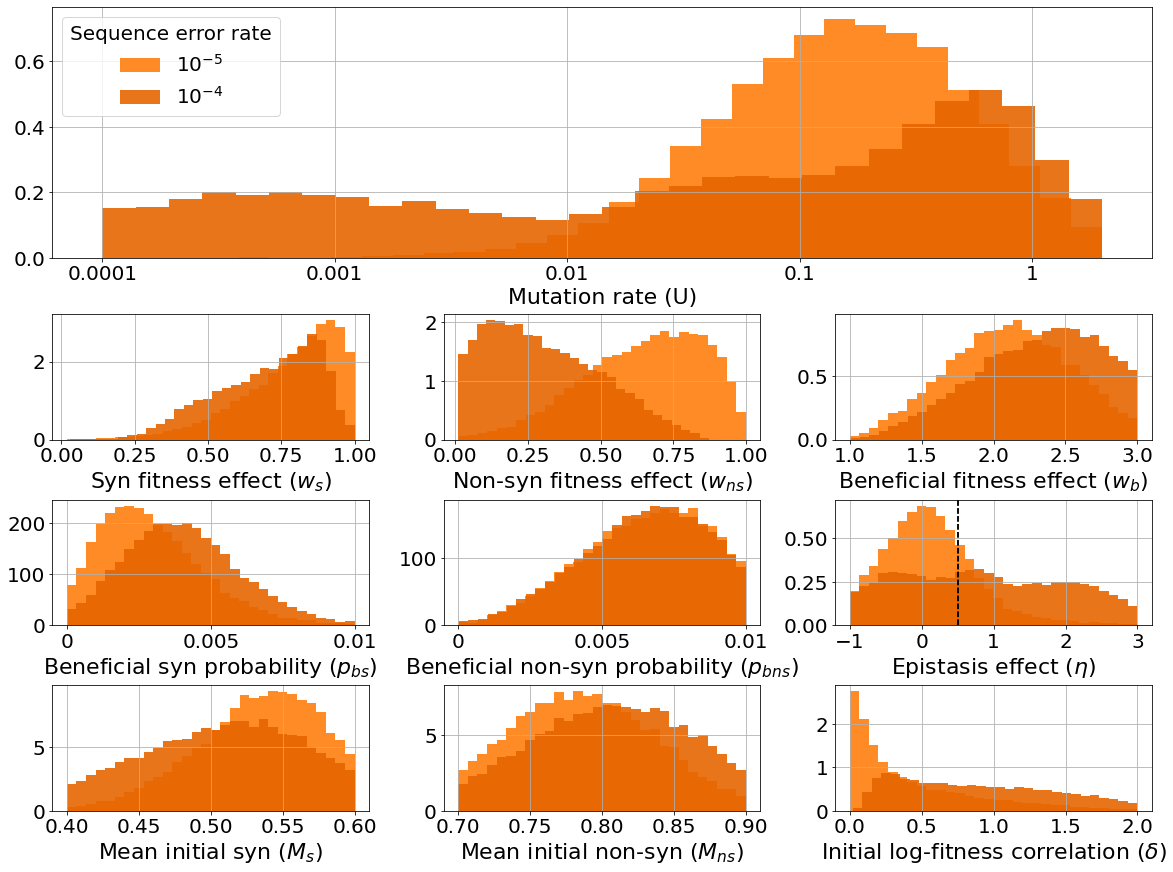

In [48]:
SR_errs = {r'$10^{-5}$': pd.concat([x[0] for x in inf_SR.values()]),
            r'$10^{-4}$': pd.concat([x[0] for x in large_errs_SR.values()])}
not_C1 = [max(x-0.1,0) for x in sns.color_palette()[1]]
compare_posts(SR_errs, mu_xticks=(-4,1), legend_title='Sequence error rate',
                             colors=['C1', not_C1], alpha=0.9)